# Neural Networks

In [1]:
# Import some helper functions (please ignore this!)
from utils import *

**Context:** So far, we've focused on translating our IHH colleague's goals into probabilistic models, and then fitting these models to data to help them answer scientific questions. In each model's conditional distributions, we've had to make two choices: what distribution to use, and how the distributions parameter should depend on the condition. For example, in regression, recall we picked the following conditional distribution:
\begin{align}
p_{Y | X}(\cdot | x_n; \underbrace{W, \sigma}_{\theta}) = \mathcal{N}( \underbrace{\mu(x_n; W)}_{\text{trend}}, \underbrace{\sigma^2}_{\text{noise}} ),
\end{align}
where $\mu(x_n; W)$ represents the "trend" of the data. We've had to decide whether $\mu(x_n; W)$ should be linear, polynomial, or some other function. As our data grows in complexity---for example, as $x_n$ becomes high-dimensional---it becomes increasingly difficult to make up functions that are, expressive, fast, and easy to code. We will show you why below. 

**Challenge:** So what functions should be use in our probabilistic models? Here, we will introduce a new type of function---a *neural network*. As we will show here, neural networks are expressive, fast, and easy to code. 

**Outline:** 
* Shortcomings of other expressive functions, likely polynomials
* The idea behind neural networks: using function composition to create expressive functions
* Introduce *a little bit* of linear algebra to help introduce neural networks
* Introduce neural networks, implement them in `NumPyro` and fit them to IHH data
* Connect the math behind neural networks to the pictures used to represent them in popular media

## The Shortcomings of Polynomials

**The Universality of Polynomials.** In both chapters about regression and classification, we observed the benefits of using non-linear functions for data with non-linear trends. In regression, we've focused on polynomials as our primary tool for creating non-linear functions, and for our low-dimensional data, they seemed to work great! So you may be wondering, why not apply them to high-dimensional data as well? In fact, polynomials boast a very powerful property: they are *universal function approximators*. By this, we mean that for any continuous function on some bounded interval $[a, b]$, we can find a polynomial that approximates it arbitrarily well (this is known as the [Stone–Weierstrass theorem](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem)). This means that for *any* data set that consists of continuous trends, *theoretically speaking*, polynomials can capture it. This is a huge deal! So let's see how polynomials measure up against a neural network:

```{figure} _static/figs/example_regression_inductive_bias_percent_ood_0.png
---
name: fig-regression-inductive-bias-closeup
align: center
---
Examples of polynomial and neural network regression on IHH data.
```

As you can see, polynomial regression seems to capture the trend in these regression data sets super well---so why aren't they as famous as neural networks? Polynomial regression actually comes with several challenges that make it inappropriate in many contexts. 

**Challenge 1: Numerical Instability.** Polynomials are numerically unstable. Imagine you want to use a degree-20 polynomial in your regression model. This means that, in fitting your model, you will have to evaluate $x^20$. When $x = 0.1$ and when $x = 10.0$, you're asking your computer to represent numbers like $0.000000000000000000001$ and $1000000000000000000000$. Because your computer only has finite precision, very small numbers are at risk of being rounded down to $0$ and very large numbers may overflow. 

**Challenge 2: Inductive Bias.** Oftentimes, we're less interested in seeing what our model does on data we've already observed. Instead, we want to know what it might do for a *new* data point. For example, suppose we're asked to develop a model to predict telekinetic ability and glow from age (like we did in the regression chapter). We aren't interested in seeing the model's predictions on patients included in our data set---we've already observed these patients' age, telekinetic ability, and glow. What we're we're interested in is the model's predictions for *new* patients. For example, what happens if we get an input that we've never seen before, like a patient that's much older or younger than the rest of the patients in the data.

We call the trend of the model away from the data its "inductive bias." Different models that fit the data equally well may actually have different inductive biases. Let's illustrate what we mean visually. In the plot above, you see that the 5th and 6th-degree polynomials both fit the data equally well. But what would they predict for points away from our data? And will their predictions be medically reasonable? Let's have a look: the plot below shows the very same models from the plot above, but this time the plots are zoomed out. In this way you can see each model's behavior away from the data. As you can see, each model's inductive bias is different.

```{figure} _static/figs/example_regression_inductive_bias_percent_ood_30.png
---
name: fig-regression-inductive-bias
align: center
---
A zoomed-out plot of the same models from the figure above.
```

What's interesting in the above plot is that the polynomial regression's inductive bias tends towards positive or negative infinity very quickly. Looking at the math, this makes sense: a 5th or 6th-degree polynomial will include terms like $\text{age}^5$, which grow quickly with age.

While this may be the desired behavior for some data sets, for our data sets, it's inappropriate. For example, look at the left-middle plot, in which the 5th-degree polynomial regression predicts telekinetic ability from age. Even though we've generally seen that as age increases, telekinetic ability decreases, this plot suggests the opposite. After age 100, the patient's telekinetic ability *skyrockets*; in fact, it increases so quickly it's larger than the ability of all other patients. While in comparison, the neural network's inductive bias doesn't seem obviously inappropriate, that doesn't mean that it is appropriate. It's important to remember that neural networks, like any other function, have inductive biases that are useful for *some* tasks and not for others.

**Conclusion:** When picking a function-class to work with (like the class of polynomials), it's important to consider numerical stability (as well as ease of optimization). Without these properties, it doesn't matter how expressive your function is, since you'll never be able to practically fit it to data. Second, it's important to think about the function class's inductive bias, or in other words, to think about how it will generalize in regions of the space where data is scarce. 

## Expressive Functions from Simple Building Blocks

**Idea.** Instead of using polynomials, let's see if we can build an expressive function-class, $\mu(\cdot; W)$, from small building blocks. Each block will be simple and numerically stable. And when combined, will give us an expressive function, capable of adapting to any trend we observe in the data. This is the mechanism underlying neural networks.

Let's import some libraries so we can plot as we go.

In [2]:
import jax.numpy as jnp
import jax.random as jrandom
import jax.nn as jnn
import numpyro.distributions as D

**A Simple Block.** For the simple block, let's use a sigmoid. A sigmoid looks like a smoothed-out step function:

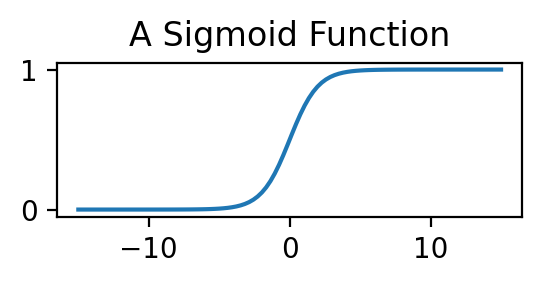

In [3]:
plt.figure(figsize=(3, 1))

# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# Plot the sigmoid
plt.plot(x, jnn.sigmoid(x))

plt.title('A Sigmoid Function')
plt.show()

We will give the sigmoid two parameters, which we will learn from data, giving us our simple building block:
\begin{align}
u(x; w, b) &= \mathrm{sigmoid}( \underbrace{w \cdot x + b}_{\text{horizontal scale \& shift}} )
\end{align}
Here, $b$ shifts the sigmoid left/right, and $w$ stretches/shrinks the overall sigmoid horizontally. Let's see what this looks like for different choices of choices of $w$ and $b$:

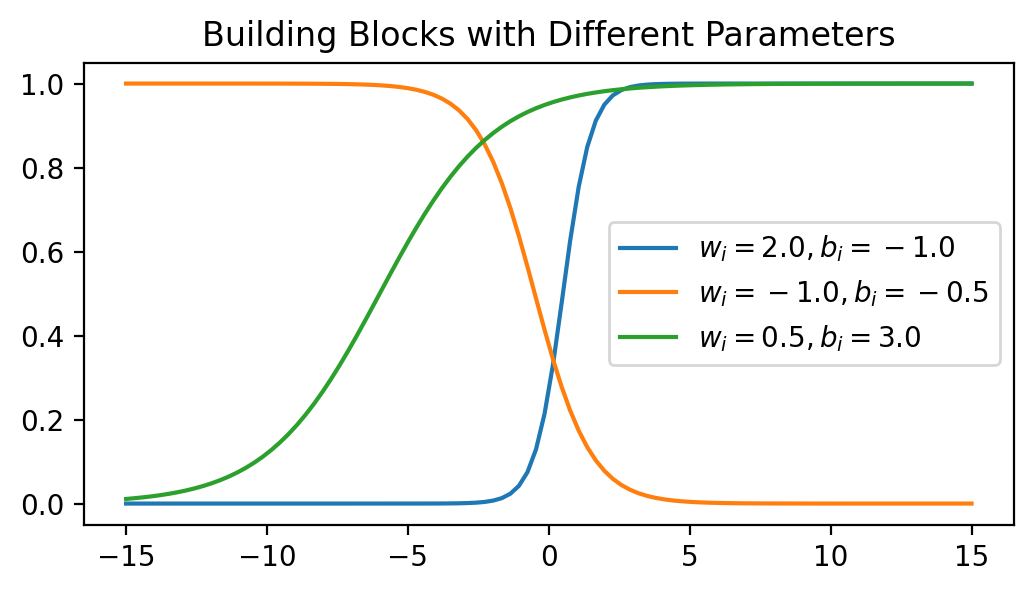

In [4]:
# Choose some scales and shifts
scale = [2.0, -1.0, 0.5]
shift = [-1.0, -0.5, 3.0]

# Plot!
plt.figure(figsize=(6, 3))

# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# For each set w, b plot the function
for w, b in zip(scale, shift):
    plt.plot(x, jnn.sigmoid(w * x + b), label=r'$w_i = {}, b_i = {}$'.format(w, b))
    
plt.title('Building Blocks with Different Parameters')
plt.legend()
plt.show()

Of course, the above example is only for a 1-dimensional input. Ideally, our function class will work for higher-dimensional inputs. We can incorporate this into our simple block as follows. We define $D$ to be the dimension of the inputs, $x$, and we sum over the scaled and shifted inputs as follows:
\begin{align}
u(x; w, b) &= \mathrm{sigmoid}\left( \sum\limits_{d=1}^D \underbrace{w_d \cdot x^{(d)} + b_d}_{\text{horizontal scale \& shift}} \right)
\end{align}
where $x^{(d)}$ denotes the $d$-th dimension of $x$, and $w = \{ w_1, \dots w_d \}$ and $b = \{ b_1, \dots b_d \}$ have a different scale and shift for every dimension.

This unassuming building block, $u(x; w, b)$, is actually called a *neuron*. We will next start combining these neurons to form a full neural network. 

**Combining Building Blocks via Addition.** As we've seen when plotting our building block (or neuron), it can't really model anything too interesting. However, by adding these neurons together with different parameters, we can start making more interesting-looking functions. To get some intuition, let's start with a simple experiment---we'll add the three neurons from the plot above and see what kind of function we get:

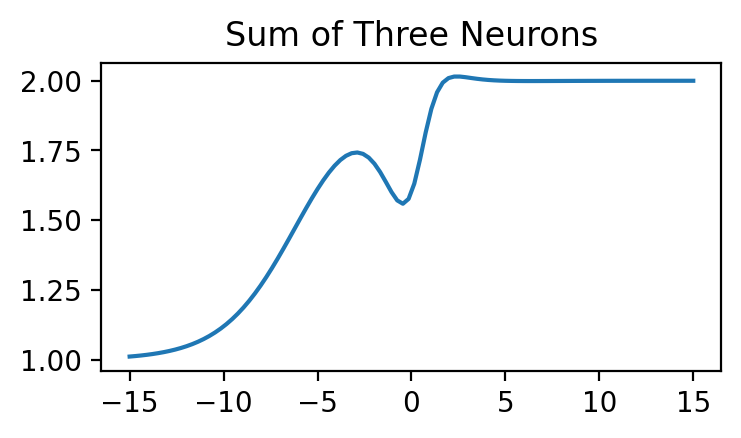

In [8]:
# Domain on which to visualize our functions
x = jnp.linspace(-15.0, 15.0, 100)

# Compute the sum of the blocks
y = 0.0
for w, b in zip(scale, shift):  
    y += jnn.sigmoid(w * x + b)

# Plot!
plt.figure(figsize=(4, 2))
plt.plot(x, y)
plt.title('Sum of Three Neurons')
plt.show()

As you can see, this function already looks a lot more interesting than a sigmoid on its own. Now, let's formally decide how to combine neurons into a function.

Recall that a sigmoid always outputs a value in $[0, 1]$. Because of this, $u(\cdot; w, b)$ will also only output values in $[0, 1]$. To represent functions outside of this limited range, we will apply a scale and shift like before, and then sum over a group of $L$ of these neurons:
\begin{align}
f(x; W, b) &= \sum\limits_{l=1}^L \underbrace{w_l^\text{out} \cdot u(x; w_l^\text{in}, b_l^\text{in}) + b_l^\text{out}}_{\text{vertical scale and shift neuron}}
\end{align}
where 
\begin{align}
W &= \{ w_1^\text{in}, \dots, w_L^\text{in}, w_1^\text{out}, \dots, w_L^\text{out} \} \\
b &= \{ b_1^\text{in}, \dots, b_L^\text{in}, b_1^\text{out}, \dots, b_L^\text{out} \}
\end{align}

So what kind of functions can be captured by $f(\cdot; W, b)$? 
1. Let's plot functions composed of $L = 10$ neurons.
2. So that we don't have to pick values of $W$ and $b$ by hand, let's draw them from some distribution. Here, we'll go with a Normal distribution.
3. We'll repeat the process $N$ times to get a sense of the variety of functions $f(\cdot; W, b)$ can represent.

Let's see what happens:

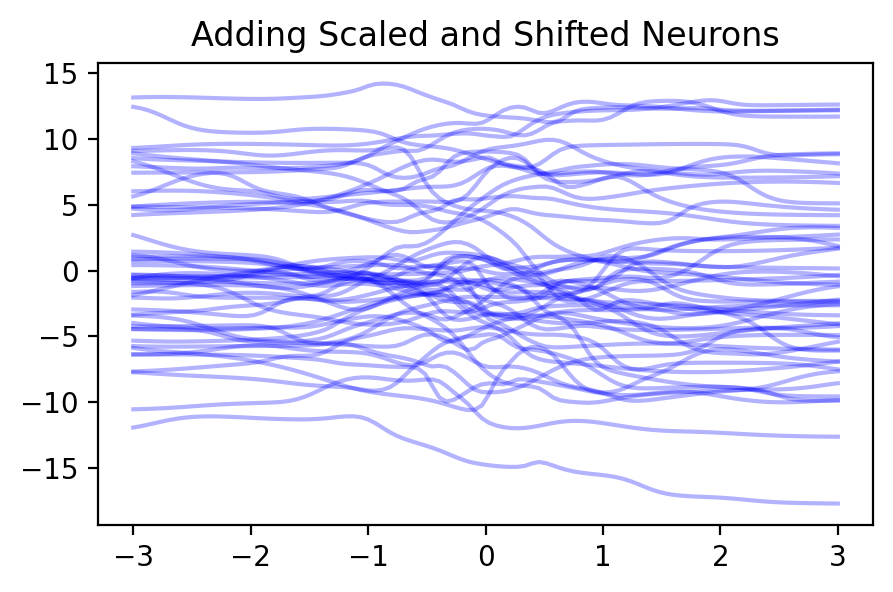

In [38]:
# Number of building blocks to add
L = 30

# Number of functions to plot
N = 50

# Domain on which to visualize our functions
x = jnp.linspace(-3.0, 3.0, 100)

# Create one random key per function
key = jrandom.PRNGKey(seed=0)
key_per_function = jrandom.split(key, N)

plt.figure(figsize=(5, 3))

for k in key_per_function:
    key_W_in, key_W_out, key_b_in, key_b_out = jrandom.split(k, 4)

    # Generate the parameters of the block from a Normal distribution
    W_in = D.Normal(0.0, 10.0).sample(key_W_in, (L, 1))
    b_in = D.Normal(0.0, 10.0).sample(key_b_in, (L, 1))

    W_out = D.Normal(0.0, 1.0).sample(key_W_out, (L, 1))
    b_out = D.Normal(0.0, 1.0).sample(key_b_out, (L, 1))

    # Use some "broadcasting" magic to efficiently sum the building blocks
    h = (W_out * jnn.sigmoid(W_in * x + b_in) + b_out).sum(axis=0)
    
    # Plot!
    plt.plot(x, h, alpha=0.3, color='blue')

plt.title('Adding Scaled and Shifted Neurons')
plt.show()

Now we're getting wiggly! Given how many different functions $f(\cdot; W, b)$ can represent, you can imagine that by learning the parameters, $W$ and $b$, from data, we can capture the data trends accurately. Moreover, notice that, unlike polynomials, there's nothing about $f(\cdot; W, b)$ that is numerically unstable. Each neuron is a sigmoid, so its range is between $[0, 1]$; therefore, summing up the sigmoids together to get $f(\cdot; W, b)$ doesn't blow up like a polynomial.

The function we arrived at, $f(\cdot; W, b)$, is called a *neural network*. We can plug it into our regression or classification models and learn the parameters, $\theta = \{ W, b \}$, via MLE. 

**Combining Building Blocks via Composition.** We can make the neural network we've created so far *even more expressive* using function composition. By "composition," we mean that we apply a function to the output of another function. For example, if we have two functions, $f(x)$ and $g(x)$, their composition is $f(g(x))$. 

## Multivariate Linear Transforms

Suppose we're developing a regression model for high-dimensional data and need to pick which $\mu(\cdot; W)$ to use. Let our input data be $D$ dimensional, meaning that our inputs are an array (or vector): $x_n = [ x_n^{(1)}, x_n^{(2)}, \dots, x_n^{(D)} ]$. We use the superscript to denote the dimension of the data. 

## Neural Networks

## Connecting the Pictures to the Math